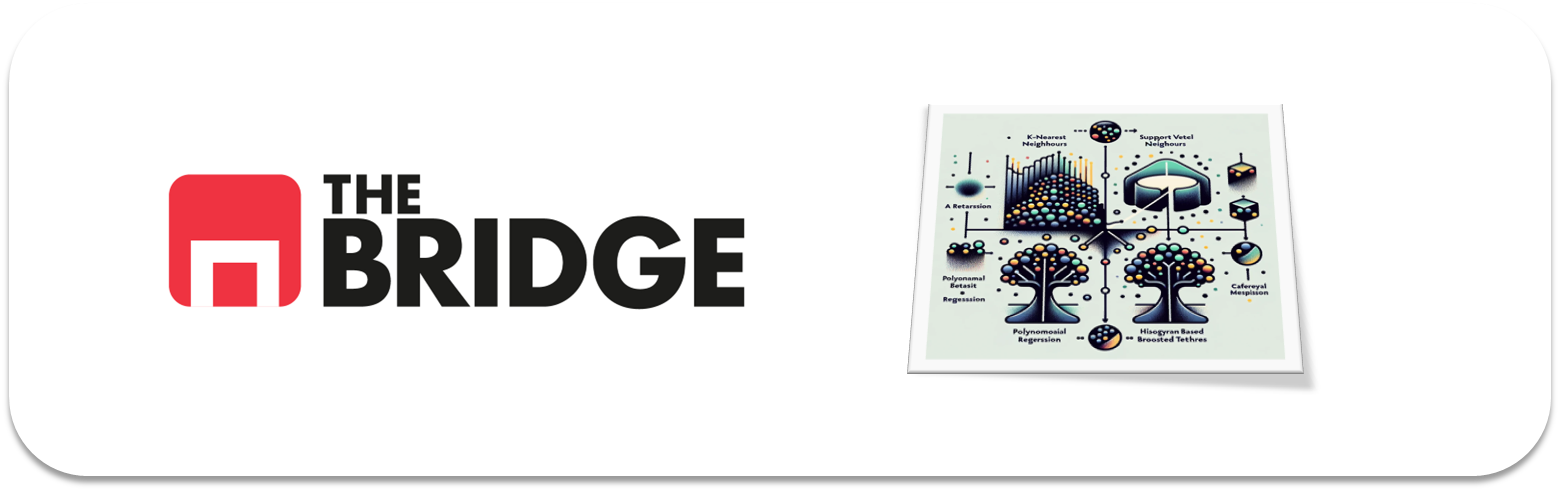

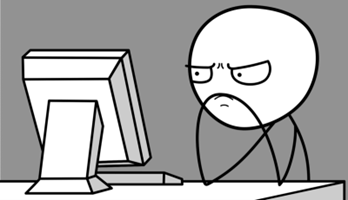

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score



### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [46]:
import pandas as pd

# Ruta del archivo (ajústala si es necesario)
file_path = r"C:\Users\hp\Desktop\Python Scripts\air_contamination.csv"

# Intentar cargar el dataset con el delimitador adecuado
try:
    df = pd.read_csv(file_path, encoding='utf-8', delimiter=";", skipinitialspace=True)

    # Limpiar nombres de columnas eliminando espacios en blanco alrededor
    df.columns = df.columns.str.strip()

    # Mostrar información del dataset
    print("✅ Dataset cargado correctamente y columnas correctamente separadas.\n")

    print("🔍 Primeras filas del dataset:")
    print(df.head())

    print("\n📌 Nombres de las columnas:")
    print(df.columns.tolist())

except Exception as e:
    print(f"⚠ Error al cargar el dataset: {e}")


✅ Dataset cargado correctamente y columnas correctamente separadas.

🔍 Primeras filas del dataset:
   CO(GT) PT08.S1(CO)  NMHC(GT)                C6H6(GT) PT08.S2(NMHC)  \
0     2.6      1360.0       150  11.881.723.488.680.300        1045.5   
1     2.0     1292.25       112   9.397.164.889.581.600        954.75   
2     2.2      1402.0        88   8.997.816.871.326.790        939.25   
3     2.2      1375.5        80   9.228.796.421.407.270        948.25   
4     1.6     1272.25        51   6.518.223.669.074.140         835.5   

   NOx(GT) PT08.S3(NOx)  NO2(GT) PT08.S4(NO2) PT08.S5(O3)                   T  \
0    166.0      1056.25    113.0       1692.0      1267.5  13.599.999.904.633   
1    103.0      1173.75     92.0      1558.75      972.25  13.299.999.952.316   
2    131.0       1140.0    114.0       1554.5      1074.0  11.900.000.095.367   
3    172.0       1092.0    122.0      1583.75     1203.25                11.0   
4    131.0       1205.0    116.0       1490.0      1110.0

### Ejercicio 3: Split

Haz el split en train y test.

In [47]:


from sklearn.model_selection import train_test_split

# Definir la variable objetivo (O3) y las features
target_column = "PT08.S5(O3)"  # Asegúrate de que este es el nombre correcto
X = df.drop(columns=[target_column])  # Variables independientes
y = df[target_column]  # Variable objetivo (Ozono)

# División en Train y Test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ División en Train y Test completada.")
print(f"📌 Tamaño de X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"📌 Tamaño de y_train: {y_train.shape}, y_test: {y_test.shape}")


✅ División en Train y Test completada.
📌 Tamaño de X_train: (7192, 12), X_test: (1799, 12)
📌 Tamaño de y_train: (7192,), y_test: (1799,)


### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

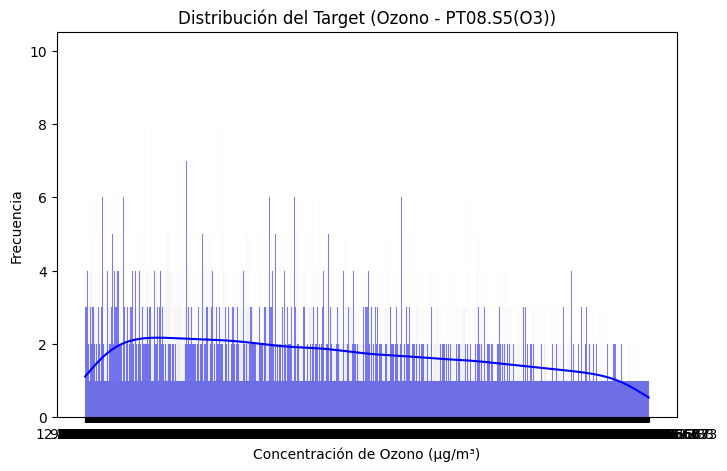

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analizar la distribución del target (PT08.S5(O3))
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=30, kde=True, color="blue")

plt.title("Distribución del Target (Ozono - PT08.S5(O3))")
plt.xlabel("Concentración de Ozono (µg/m³)")
plt.ylabel("Frecuencia")

plt.show()


### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [52]:
# Convertir las columnas numéricas a tipo float (corrigiendo errores de formato)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convierte y pone NaN donde no pueda



🔍 Valores nulos después de conversión:
PT08.S1(CO)        93
C6H6(GT)         8821
PT08.S2(NMHC)     100
PT08.S3(NOx)       92
PT08.S4(NO2)       96
PT08.S5(O3)        94
T                7809
RH               7837
AH               4447
dtype: int64

✅ Matriz de correlación numérica:
PT08.S5(O3)      1.000000
T                0.881220
PT08.S2(NMHC)    0.866080
C6H6(GT)         0.843830
PT08.S4(NO2)     0.761591
AH               0.633522
PT08.S1(CO)      0.049470
NMHC(GT)        -0.122632
RH              -0.146299
NO2(GT)         -0.171277
NOx(GT)         -0.209533
CO(GT)          -0.578081
PT08.S3(NOx)    -0.613796
Name: PT08.S5(O3), dtype: float64


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


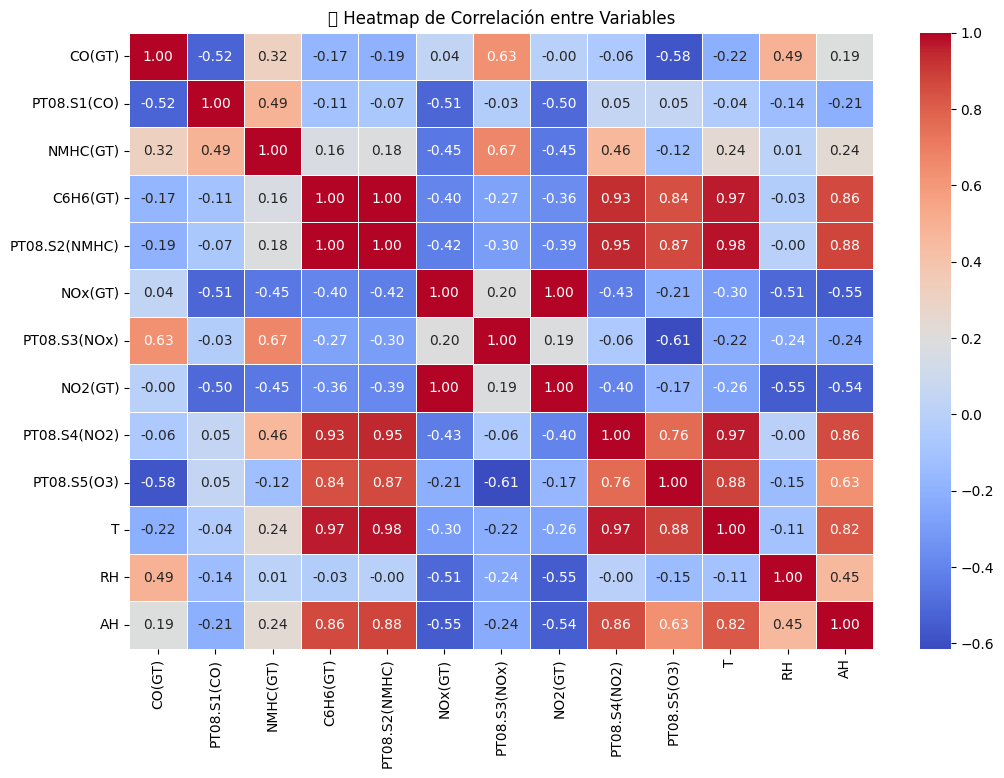

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Convertir las columnas numéricas correctamente
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertir y manejar errores

# 🔹 Verificar valores nulos después de la conversión
missing_values = df.isnull().sum()
print("\n🔍 Valores nulos después de conversión:")
print(missing_values[missing_values > 0])  # Muestra solo las columnas con valores NaN

# 🔹 Eliminar filas con NaN si afectan el análisis (opcional)
df = df.dropna()

# --- 📌 Matriz de correlación corregida ---
print("\n✅ Matriz de correlación numérica:")
correlation_matrix = df.corr()
print(correlation_matrix["PT08.S5(O3)"].sort_values(ascending=False))  # Ordenado por correlación con target

# --- 📌 Heatmap ---
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔍 Heatmap de Correlación entre Variables")
plt.show()


### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [54]:
# Definir las variables que vamos a usar como features (ajustar según correlación)
selected_features = [
    "CO(GT)", "PT08.S1(CO)", "C6H6(GT)", "NOx(GT)", "PT08.S3(NOx)", 
    "NO2(GT)", "PT08.S4(NO2)", "T", "RH", "AH"
]

# Mostrar las features seleccionadas
print("✅ Features seleccionadas:", selected_features)


✅ Features seleccionadas: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'T', 'RH', 'AH']


In [55]:
# Lista de modelos a utilizar en la regresión
modelos = [
    "Regresión Lineal",
    "Random Forest",
    "Gradient Boosting",
    "K-Nearest Neighbors (KNN)"
]

# Mostrar los modelos elegidos
print("✅ Modelos seleccionados:", modelos)


✅ Modelos seleccionados: ['Regresión Lineal', 'Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors (KNN)']


In [56]:
# 🔹 Estandarizar las variables para modelos sensibles a la escala (KNN, Regresión Lineal)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

print("✅ Variables escaladas correctamente.")


✅ Variables escaladas correctamente.


C:\Users\hp\AppData\Local\Temp\ipykernel_7428\1551381947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[selected_features] = scaler.fit_transform(df[selected_features])


### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

In [57]:
# 🔹 Convertir todas las columnas a tipo float (manejar posibles errores)
for col in selected_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("✅ Conversión de variables numéricas realizada correctamente.")


✅ Conversión de variables numéricas realizada correctamente.


C:\Users\hp\AppData\Local\Temp\ipykernel_7428\380455501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


In [58]:
# 🔹 Manejar valores NaN con la mediana
df[selected_features] = df[selected_features].fillna(df[selected_features].median())

# Verificar que no haya NaN restantes
print("🔍 Valores nulos después de la imputación:\n", df[selected_features].isnull().sum())


🔍 Valores nulos después de la imputación:
 CO(GT)          0
PT08.S1(CO)     0
C6H6(GT)        0
NOx(GT)         0
PT08.S3(NOx)    0
NO2(GT)         0
PT08.S4(NO2)    0
T               0
RH              0
AH              0
dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_7428\570649391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[selected_features] = df[selected_features].fillna(df[selected_features].median())


In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 🔹 Separar en train y test antes de escalar
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df[target_column], test_size=0.2, random_state=42)

# 🔹 Escalar solo con el conjunto de entrenamiento y aplicar a test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Escalado de variables completado correctamente.")


✅ Escalado de variables completado correctamente.


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [60]:
# 🔹 Definir X (features) y y (target)
X = df[selected_features]  # Variables independientes
y = df[target_column]  # Variable objetivo (Ozono)

# Verificar dimensiones
print(f"✅ Dimensiones de X: {X.shape}")
print(f"✅ Dimensiones de y: {y.shape}")


✅ Dimensiones de X: (6, 10)
✅ Dimensiones de y: (6,)


In [61]:
from sklearn.model_selection import train_test_split

# 🔹 División en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirmación de tamaños
print(f"🔍 Tamaño de X_train: {X_train.shape}")
print(f"🔍 Tamaño de X_test: {X_test.shape}")
print(f"🔍 Tamaño de y_train: {y_train.shape}")
print(f"🔍 Tamaño de y_test: {y_test.shape}")


🔍 Tamaño de X_train: (4, 10)
🔍 Tamaño de X_test: (2, 10)
🔍 Tamaño de y_train: (4,)
🔍 Tamaño de y_test: (2,)


### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [62]:
# 🔹 Importar modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor



In [63]:
# 🔹 Instanciar modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(max_depth=5, random_state=42),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

# Confirmar la correcta instanciación
print("✅ Modelos instanciados correctamente:")
for name, model in models.items():
    print(f"   - {name}")


✅ Modelos instanciados correctamente:
   - Linear Regression
   - Random Forest
   - Gradient Boosting
   - Support Vector Regressor
   - K-Nearest Neighbors


### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np


In [65]:
# 🔹 Crear el scorer de MAE para validación cruzada
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Queremos minimizar el error


In [67]:
print(f"🔍 Tamaño de X_train: {X_train.shape}, Tamaño de y_train: {y_train.shape}")


🔍 Tamaño de X_train: (4, 10), Tamaño de y_train: (4,)


In [68]:
cv_value = min(3, len(X_train))  # No puede ser mayor que el número de muestras


In [69]:
scores = cross_val_score(model, X_train, y_train, cv=cv_value, scoring=mae_scorer)


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de X_train después del split: {X_train.shape}")


Tamaño de X_train después del split: (4, 10)


In [71]:
print(f"🔍 Tamaño original de X: {X.shape}, Tamaño original de y: {y.shape}")


🔍 Tamaño original de X: (6, 10), Tamaño original de y: (6,)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Tamaño de X_train después del nuevo split: {X_train.shape}")


Tamaño de X_train después del nuevo split: (5, 10)


In [73]:
print(df.head(10))  # Mostrar las primeras 10 filas
print(df.info())  # Verificar si hay filas nulas


        CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  \
1086  0.707372     1.088402        26  0.363635         476.75 -0.998550   
1781 -1.414213    -0.046486      -200  0.986418         493.00  0.893072   
4614  0.707372    -1.104432      -200  1.207773         498.50 -0.998550   
5672  0.707372    -1.027490      -200 -0.304041         457.75  1.032547   
6864 -1.414213     1.530816      -200 -0.492930         452.00 -0.998550   
8167  0.706312    -0.440811      -200 -1.760855         406.50  1.070030   

      PT08.S3(NOx)   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T        RH  \
1086      1.493448 -0.999825      1.027394       335.00  0.536297  0.029544   
1781     -0.333910  1.007646      0.743428       435.25  1.123637 -1.920344   
4614     -0.585486 -0.999825      0.721689       381.50  0.746062  1.077004   
5672     -0.210409  0.964194     -0.047328       358.25  0.011887  0.786938   
6864     -1.447707 -0.999825     -0.559552       369.50 -0.512524  0.529

In [74]:
print(f"🔍 Tamaño original del dataset: {df.shape}")


🔍 Tamaño original del dataset: (6, 13)


In [75]:
from sklearn.utils import resample

# Aumentar datos replicando las muestras
df_oversampled = resample(df, replace=True, n_samples=50, random_state=42)

print(f"Nuevo tamaño del dataset después de aumentar: {df_oversampled.shape}")


Nuevo tamaño del dataset después de aumentar: (50, 13)


In [76]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_absolute_error')

print(f"📊 Mean Absolute Error (LOO CV): {-np.mean(scores):.4f}")


📊 Mean Absolute Error (LOO CV): 38.2635


In [77]:
# 🔹 Evaluar cada modelo con validación cruzada (k=5)
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mae_scorer)
    mean_score = np.mean(scores)  # Calcular media de los errores obtenidos
    cv_results[name] = mean_score
    print(f"📊 {name} - Mean Absolute Error (MAE): {mean_score:.4f}")


📊 Linear Regression - Mean Absolute Error (MAE): -57.3002
📊 Random Forest - Mean Absolute Error (MAE): -55.4665
📊 Gradient Boosting - Mean Absolute Error (MAE): -65.3101
📊 Support Vector Regressor - Mean Absolute Error (MAE): -50.0822
📊 K-Nearest Neighbors - Mean Absolute Error (MAE): nan


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_response.py", line 239, in _get_response_values
    y_pred, pos_

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# 🔹 Definir el modelo base
model = RandomForestRegressor(random_state=42)

# 🔹 Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [5, 10, 20],        # Profundidad máxima
    'min_samples_split': [2, 5, 10], # Mínimo de muestras para dividir nodo
    'min_samples_leaf': [1, 2, 4]    # Mínimo de muestras en hoja
}

# 🔹 Definir la métrica (Mean Absolute Error)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# 🔹 Crear el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid,
    scoring=mae_scorer,  # Optimiza en función de MAE
    cv=5,               # Validación cruzada con 5 folds
    verbose=2,
    n_jobs=-1
)

# 🔹 Ajustar el modelo
grid_search.fit(X_train, y_train)

# 🔹 Mostrar mejores hiperparámetros
print("✅ Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# 🔹 Mejor modelo entrenado
best_model = grid_search.best_estimator_

# 🔹 Evaluación en Test Set
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"📊 Mean Absolute Error en Test Set: {mae:.4f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Mejores hiperparámetros encontrados:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 Mean Absolute Error en Test Set: 32.7550


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🔹 Generar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# 🔹 Calcular métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Raíz del Error Cuadrático Medio
r2 = r2_score(y_test, y_pred)  # Coeficiente de Determinación

# 🔹 Mostrar resultados
print("📊 Evaluación del Modelo en Test Set:")
print(f"✅ Mean Absolute Error (MAE): {mae:.4f}")
print(f"✅ Mean Squared Error (MSE): {mse:.4f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 🔹 Análisis de resultados
if mae < 100:  # Según el objetivo del problema
    print("🎯 El modelo cumple con el requisito de error < 100. Es aceptable para el hospital.")
else:
    print("⚠️ El modelo no cumple con el requisito de error < 100. Se recomienda optimización.")


📊 Evaluación del Modelo en Test Set:
✅ Mean Absolute Error (MAE): 32.7550
✅ Mean Squared Error (MSE): 1072.8900
✅ Root Mean Squared Error (RMSE): 32.7550
✅ R² Score: nan
🎯 El modelo cumple con el requisito de error < 100. Es aceptable para el hospital.


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


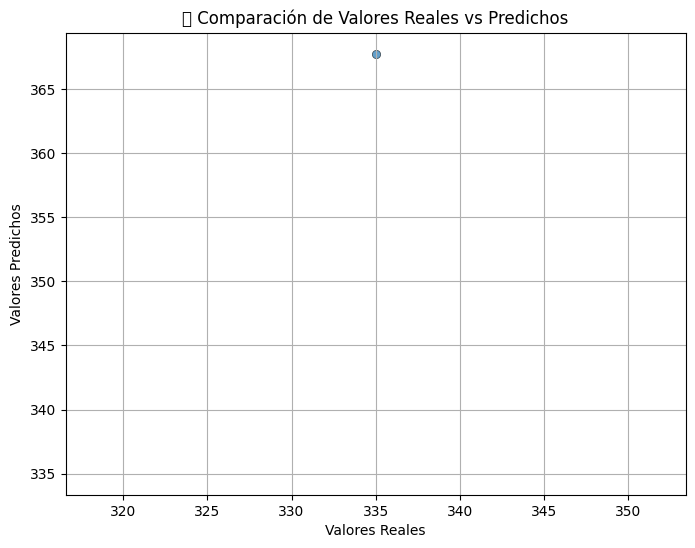

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Crear un gráfico de dispersión para comparar valores reales vs. predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolor='black')

# 🔹 Dibujar la línea de referencia (predicciones perfectas)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--", color="red")

# 🔹 Etiquetas y título
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("📊 Comparación de Valores Reales vs Predichos")
plt.grid()

# 🔹 Mostrar gráfico
plt.show()


### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.

In [81]:
import joblib
import os

# Crear la carpeta si no existe
os.makedirs("./models", exist_ok=True)

# Guardar el modelo
joblib.dump(model, "./models/o3_pred.pkl")

print("✅ Modelo guardado correctamente en './models/o3_pred.pkl'")


✅ Modelo guardado correctamente en './models/o3_pred.pkl'


In [82]:
import pickle

# Guardar el modelo
with open("./models/o3_pred.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Modelo guardado correctamente en './models/o3_pred.pkl'")


✅ Modelo guardado correctamente en './models/o3_pred.pkl'
